# QAOA Weighted MAXSAT

Gahwon Lee, Andrew Tan

In [25]:
import qiskit
import numpy as np
import random as rand
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Introduction

### Weighted MAXSAT (3-SAT)

Given a boolean formula in conjunctive normal form as well as weights to each of those clauses, find the set of boolean variables that maximize the weights. For example, if a clause with weight 3 is true, then add 3 to the total weight. Each clause can contain exactly three boolean variables.

### QAOA

Quantum Approximation Optimization Algorithm is designed to approximate the Quantum Adiabatic Algorithm by splitting up different time slices into separate gates. Since it approximates the QAA, as the number of gates increases to infinity, the QAOA result will also increase to the ideal state.

## Methods

### Encoding Qubits

The bitstring corresponding to the output of QAOA will be the input qubits. Each qubit will either be 1 for true or 0 for false. 

### Cost and Driver Hamiltonians *C* and *B*

(3-SAT) $C = \sum_{m=0}^M I-\frac{1}{2}((I_1 \pm Z_1)\otimes (I_2 \pm Z_2)\otimes (I_3 \pm Z_3))$

(2-SAT) $C = \sum_{m=0}^M I-\frac{1}{2}((I_1 \pm Z_1)\otimes (I_2 \pm Z_2))$

$B = \sum_{k=0}^{n-1} X_k$

### Driver Gate W

$W(\beta) = \mul_{k=1}^n$ H_k

In [4]:
def ref_gate(n, qc, q, beta):
    # W gate
    for i in range(0,n):
        qc.h(q[i])
    for i in range(1,n):
        qc.cx(q[i],q[0])
        
    # apply phase gate
    qc.u1(2*beta, q[0])
    
    for i in range(n-1,0,-1):
        qc.cx(q[i],q[0])
    for i in range(0,n):
        qc.h(q[i])

### Cost Gate V

$V(\gamma) = ...

In [5]:
def constraint_gate(n, qc, q, gamma, clauses):
    # V gate
    # 2-SAT
    
    # clause[0] is the weight
    # clauses will be in form clauses[i] = [-1*x,y] with x and y refering to the qubits we act on, and a negative value
    # means a NOT-x
    # clauses are also 1-indexed, so be sure to subtract by 1 before reading them!
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        
        
        flip = 2*(x_not == y_not) - 1 # flips if x_not xor y_not
        qc.cx(q[x],q[y])
        qc.u1(flip*-1*gamma*weight,q[y])
        qc.cx(q[x],q[y])

        flip = -(2*(x_not)-1) # x
        qc.u1(flip*-1*gamma*weight,q[x])

        flip = -(2*(y_not)-1) # y
        qc.u1(flip*-1*gamma*weight,q[y])

### Classic Solver

In [7]:
def classic(clauses, value):
    value = value[::-1]
    res = 0
    
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        
        result = ((value[x] == '1') != x_not) or ((value[y] == '1') != y_not)
        if (result):
            res += weight
            
    return res

### Calculating the Expectation
Expectation = <gamma,beta|C|gamma,beta>

In [37]:
def run_qaoa(qc,q,c,n,gamma,beta,clauses):
    for i in range(n):
        qc.h(q[i])
    p = 1
    for pp in range(p):
        constraint_gate(n, qc, q, gamma, clauses)
        ref_gate(n, qc, q, beta)

def expectation(gamma, beta, clauses):
    
    n = 3
    q = qiskit.QuantumRegister(n)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    # q[0..n-1] are input qubits
    
    run_qaoa(qc,q,c,n,gamma,beta,clauses)
    
    qc.measure(q, c)
    
    repetitions = 1024
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=repetitions)
    result = job.result().get_counts(qc)
    
    answer = 0
    for key in result.keys():
        probability = result[key] / repetitions
        answer += probability * classic(clauses, key)
        
    #print("Resulting bitstring after 1024 shot: "+str(result))

    return answer
    
print("Expectation: "+str(expectation(math.pi/6,math.pi/2, [[1,1,2],[2,-1,-2],[1,-1,2],[2,1,-2]])))

Resulting bitstring after 1024 shot: {'001': 133, '101': 132, '111': 126, '100': 131, '000': 132, '110': 132, '011': 132, '010': 106}
Expectation: 4.515625


### Classically Optimizing *γ* and *β*

Randomly pick γ and β and find the best input bitstring.

We chose this method over gradient descent because there are several local maximums for our cost function.

In [48]:
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]
max = 0
best_bitstring = ""
for i in range(8):
    beta = rand.uniform(0,math.pi)
    gamma = rand.uniform(0,math.pi/2)
    print("Expectation: "+str(expectation(gamma,beta,cnf)))
    
    n = 3
    q = qiskit.QuantumRegister(n)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    
    run_qaoa(qc,q,c,n,gamma,beta,cnf)
    qc.measure(q,c)
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=1)
    result = job.result().get_counts(qc)
    print("Resulting bitstring after 1 shot: "+str(result))
    cost = classic(cnf,next(iter(result.keys())))
    if max < cost:
        max = cost
        best_bitstring = next(iter(result.keys()))
    print("Cost of this bitstring(big is better): "+str(cost))
    
print("And the best bitstring is "+ best_bitstring+" with a cost of "+str(max))

Resulting bitstring after 1024 shot: {'001': 239, '101': 133, '111': 114, '100': 9, '000': 162, '110': 10, '011': 226, '010': 131}
Expectation: 3.224609375
Resulting bitstring after 1 shot: {'111': 1}
Cost of this bitstring(big is better): 3
Resulting bitstring after 1024 shot: {'001': 271, '101': 121, '000': 128, '111': 134, '011': 225, '110': 2, '010': 143}
Expectation: 3.2646484375
Resulting bitstring after 1 shot: {'010': 1}
Cost of this bitstring(big is better): 3
Resulting bitstring after 1024 shot: {'001': 239, '101': 129, '011': 233, '111': 134, '100': 17, '000': 129, '110': 15, '010': 128}
Expectation: 3.216796875
Resulting bitstring after 1 shot: {'011': 1}
Cost of this bitstring(big is better): 3
Resulting bitstring after 1024 shot: {'001': 1, '101': 125, '111': 131, '100': 248, '000': 123, '110': 244, '010': 152}
Expectation: 2.7587890625
Resulting bitstring after 1 shot: {'101': 1}
Cost of this bitstring(big is better): 3
Resulting bitstring after 1024 shot: {'001': 205, '

### Plotting

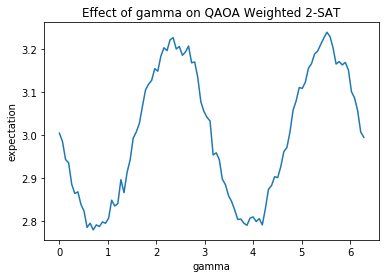

In [20]:
g = np.linspace(0, 2 * math.pi, 100)
b = 5 * math.pi / 6
'''cnf = [[1,1,2],[1,-1,2],[1,1,-2],[1,-1,-2],
       [1,1,3],[1,-1,3],[2,1,-3],[3,-1,-3],
       [1,2,3],[2,-2,3],[1,2,-3],[2,-2,-3]]'''
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]

# clause format is [weight,1st var, 2nd var]
def f(x):
    return expectation(x, b, cnf)

plt.plot(g, np.array([f(x) for x in g]))
plt.xlabel('gamma')
plt.ylabel('expectation')
plt.title('Effect of gamma on QAOA Weighted 2-SAT')
plt.show()

NameError: name 'ptl' is not defined

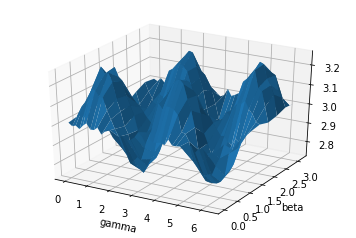

In [21]:
g = np.linspace(0, 2 * math.pi, 40)
b = np.linspace(0, math.pi, 10)
gamma, beta = np.meshgrid(g, b)
cnf = [[1,1,3],[1,-1,-2],[1,1,-3],[1,-3,2]]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gamma, beta, np.array([expectation(x, y, cnf) for x,y in zip(np.ravel(gamma), np.ravel(beta))]).reshape(gamma.shape))

plt.xlabel('gamma')
plt.ylabel('beta')

plt.title('Effect of gamma on QAOA Weighted 2-SAT')
plt.show()

## Results and Discussion

### Generate the following figures, and interpret them.  Make sure to include error bars.

blah

### For several random problem instances, plot the cost of the output state.

#### Plot average, maximum and minimum cost.  How do these compare?

blah

### Fix all parameters except one, and plot cost as a function of the free parameter.

#### Will a classical optimizer always find the best solution?

blah

## Conclusion

### Was QAOA effective in finding decent solutions?

no

### What % of the optimum solution did QAOA achieve?

0%

### Does the technique have any issues?

maybe

In [60]:
### Weighted 3SAT
def constraint_3sat(n, qc, q, gamma, clauses):
    for clause in clauses:

        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        z = abs(clause[3]) - 1
        z_not = clause[3] < 0

        flip = 2*((x_not+y_not+z_not)%2 == 0) - 1
        qc.cx(q[z],q[x])
        qc.cx(q[y],q[x])
        qc.u1(flip*-1 * gamma * weight,q[x])
        qc.cx(q[y],q[x])
        qc.cx(q[z],q[x])

        flip = 2*(z_not == y_not) - 1 # flips if z_not xor y_not
        qc.cx(q[y],q[z])
        qc.u1(flip * -1 * gamma * weight,q[z])
        qc.cx(q[y],q[z])

        flip = 2*(x_not == y_not) - 1 # flips if x_not xor y_not
        qc.cx(q[y],q[x])
        qc.u1(flip * -1 * gamma * weight,q[x])
        qc.cx(q[y],q[x])

        flip = 2*(x_not == z_not) - 1 # flips if z_not xor x_not
        qc.cx(q[z],q[x])
        qc.u1(flip * -1 * gamma * weight,q[x])
        qc.cx(q[z],q[x])

        flip = -(2*(x_not)-1) # x
        qc.u1(flip*-1*gamma*weight,q[x])

        flip = -(2*(y_not)-1) # y
        qc.u1(flip*-1*gamma*weight,q[y])

        flip = -(2*(z_not)-1) # z
        qc.u1(flip*-1*gamma*weight,q[z])


In [50]:
def classic_3sat(clauses, value):
    value = value[::-1]
    res = 0
    
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        z = abs(clause[3]) - 1
        z_not = clause[3] < 0
        
        result = ((value[x] == '1') != x_not) or ((value[y] == '1') != y_not) or ((value[z] == '1') != z_not)
        if (result):
            res += weight
            
    return res

In [58]:
def run_qaoa_3sat(qc,q,c,n,gamma,beta,clauses):
    for i in range(n):
        qc.h(q[i])
    p = 1
    for pp in range(p):
        constraint_3sat(n, qc, q, gamma, clauses)
        ref_gate(n, qc, q, beta)

def expectation_3sat(gamma, beta, clauses):
    
    n = 4
    q = qiskit.QuantumRegister(n)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    # q[0..n-1] are input qubits
    
    run_qaoa_3sat(qc,q,c,n,gamma,beta,clauses)
    
    qc.measure(q, c)
    
    repetitions = 1024
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=repetitions)
    result = job.result().get_counts(qc)
    
    answer = 0
    for key in result.keys():
        probability = result[key] / repetitions
        answer += probability * classic_3sat(clauses, key)
        
    #print("Resulting bitstring after 1024 shot: "+str(result))

    return answer
#print("Expectation: "+str(expectation(math.pi/6,math.pi/2, [[1,1,2,3],[2,1,-2,3],[1,-1,2,4],[2,1,-2,3]])))

In [64]:
cnf = [[1,1,2,3],[2,1,2,-3],[1,1,-2,3],[3,1,-2,-3],[2,-1,2,3],[1,-1,2,-3],[1,-1,-2,3],[1,-1,-2,-3]]
max = 0
best_bitstring = ""
for i in range(8):
    beta = rand.uniform(0,math.pi)
    gamma = rand.uniform(0,math.pi/2)
    print("Expectation: "+str(expectation_3sat(gamma,beta,cnf)))
    
    n = 3
    q = qiskit.QuantumRegister(n)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    
    run_qaoa_3sat(qc,q,c,n,gamma,beta,cnf)
    qc.measure(q,c)
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=1)
    result = job.result().get_counts(qc)
    print("Resulting bitstring after 1 shot: "+str(result))
    cost = classic(cnf,next(iter(result.keys())))
    if max < cost:
        max = cost
        best_bitstring = next(iter(result.keys()))
    print("Cost of this bitstring(big is better): "+str(cost))
    
print("And the best bitstring is "+ best_bitstring+" with a cost of "+str(max))

Expectation: 10.5927734375
Resulting bitstring after 1 shot: {'111': 1}
Cost of this bitstring(big is better): 10
Expectation: 10.4091796875
Resulting bitstring after 1 shot: {'110': 1}
Cost of this bitstring(big is better): 8
Expectation: 10.5224609375
Resulting bitstring after 1 shot: {'011': 1}
Cost of this bitstring(big is better): 10
Expectation: 10.5380859375
Resulting bitstring after 1 shot: {'101': 1}
Cost of this bitstring(big is better): 9
Expectation: 10.43359375
Resulting bitstring after 1 shot: {'011': 1}
Cost of this bitstring(big is better): 10
Expectation: 10.48046875
Resulting bitstring after 1 shot: {'011': 1}
Cost of this bitstring(big is better): 10
Expectation: 10.4423828125
Resulting bitstring after 1 shot: {'110': 1}
Cost of this bitstring(big is better): 8
Expectation: 10.498046875
Resulting bitstring after 1 shot: {'000': 1}
Cost of this bitstring(big is better): 9
And the best bitstring is 111 with a cost of 10


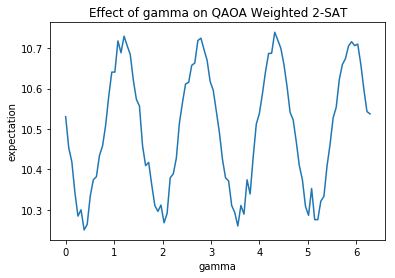

In [65]:
g = np.linspace(0, 2 * math.pi, 100)
b = 5 * math.pi / 6
cnf = [[1,1,2,3],[2,1,2,-3],[1,1,-2,3],[3,1,-2,-3],[2,-1,2,3],[1,-1,2,-3],[1,-1,-2,3],[1,-1,-2,-3]]

# clause format is [weight,1st var, 2nd var]
def f(x):
    return expectation_3sat(x, b, cnf)

plt.plot(g, np.array([f(x) for x in g]))
plt.xlabel('gamma')
plt.ylabel('expectation')
plt.title('Effect of gamma on QAOA Weighted 2-SAT')
plt.show()